In [7]:
import pandas as pd
import numpy as np
from collections import Counter
import math
from sklearn.metrics import accuracy_score

In [11]:
import pandas as pd
from collections import Counter

# Load the training dataset
df1 = pd.read_csv("train.csv")

# Check the column names to ensure the last column is the target
print(df1.columns)

# Assuming the last column is the target column (yes/no)
X_train = df1.iloc[:, :-1]  # All columns except the last one as features
y_train = df1.iloc[:, -1]   # The last column as the target (yes/no)

# Load the test dataset
df2 = pd.read_csv("test.csv")

# Check the column names to ensure consistency between train and test datasets
print(df2.columns)

# Same assumptions for the test dataset
X_test = df2.iloc[:, :-1]  # All columns except the last one as features
y_test = df2.iloc[:, -1]   # The last column as the target (yes/no)

# Optional: Check the distribution of the target values in the training set
print(Counter(y_train))


Index(['low', 'vhigh', '4', '4.1', 'big', 'med', 'acc'], dtype='object')
Index(['vhigh', 'high', '5more', '2', 'small', 'low', 'unacc'], dtype='object')
Counter({'unacc': 698, 'acc': 221, 'good': 45, 'vgood': 35})


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

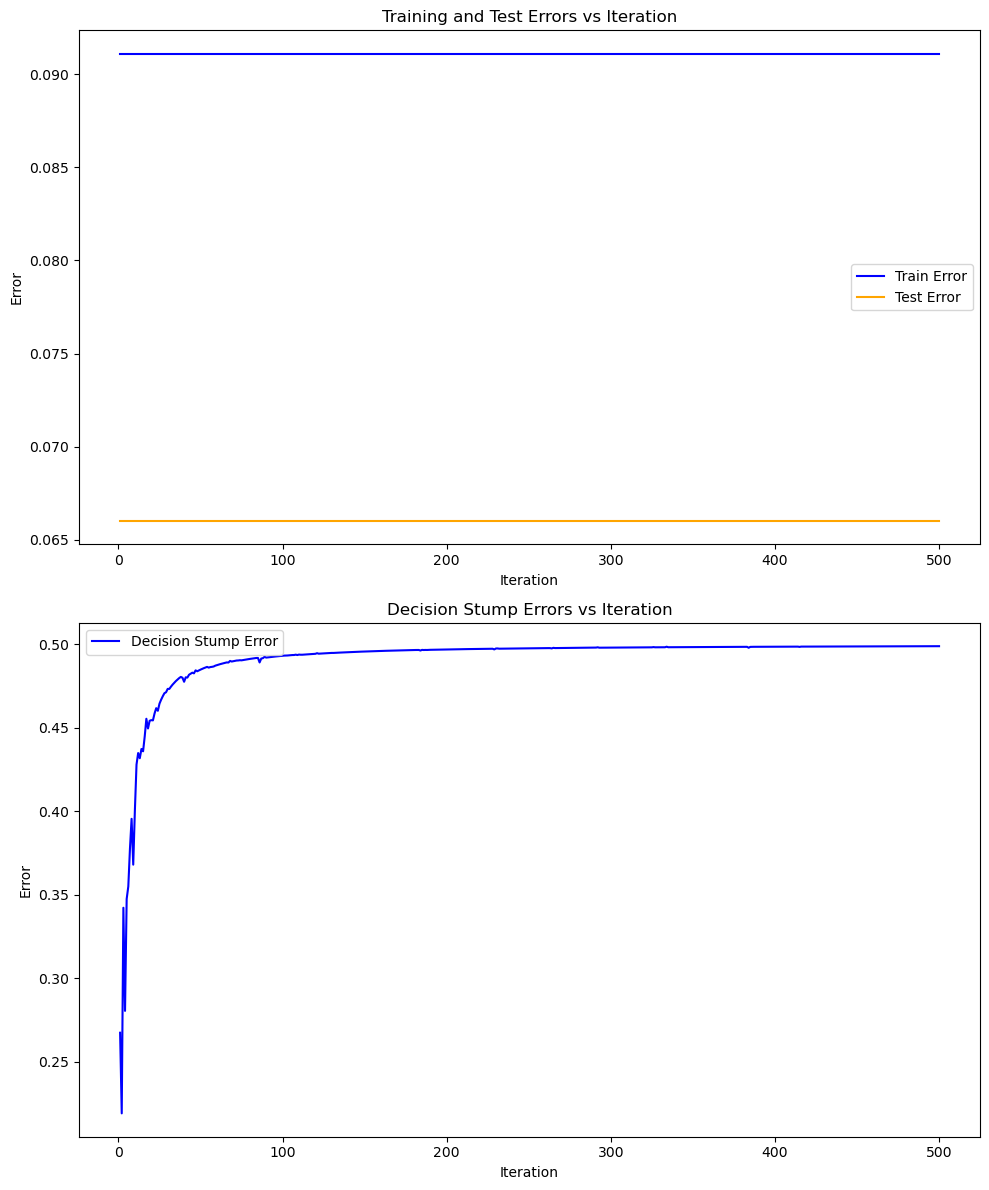

In [43]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

class DecisionStump:
    def __init__(self):
        self.feature_index = None
        self.threshold = None
        self.polarity = 1
        self.alpha = None
        self.error = None

    def fit(self, X, y, sample_weights):
        m, n = X.shape
        min_error = float('inf')

        # Iterate through each feature
        for feature_i in range(n):
            feature_values = X[:, feature_i]
            possible_thresholds = np.unique(feature_values)

            # Try each possible threshold and polarity
            for threshold in possible_thresholds:
                for polarity in [-1, 1]:
                    predictions = np.ones(m)
                    if polarity == 1:
                        predictions[feature_values < threshold] = -1
                    else:
                        predictions[feature_values > threshold] = -1

                    # Calculate the weighted error
                    error = np.sum(sample_weights * (y != predictions))

                    # Update if the error is lower
                    if error < min_error:
                        self.polarity = polarity
                        self.threshold = threshold
                        self.feature_index = feature_i
                        min_error = error

        self.error = min_error

    def predict(self, X):
        m = X.shape[0]
        predictions = np.ones(m)
        feature_values = X[:, self.feature_index]
        if self.polarity == 1:
            predictions[feature_values < self.threshold] = -1
        else:
            predictions[feature_values > self.threshold] = -1
        return predictions


class AdaBoost:
    def __init__(self, n_clf=500):
        self.n_clf = n_clf
        self.clfs = []

    def fit(self, X, y):
        m, n = X.shape
        sample_weights = np.ones(m) / m  # Initialize sample weights to be uniform
        self.clfs = []
        self.decision_stump_errors = []  # List to store errors of individual decision stumps

        # Iteratively train classifiers
        for _ in range(self.n_clf):
            clf = DecisionStump()
            clf.fit(X, y, sample_weights)

            # Calculate classifier weight (alpha)
            clf.alpha = 0.5 * np.log((1.0 - clf.error) / (clf.error + 1e-10))

            # Update the sample weights
            predictions = clf.predict(X)
            sample_weights *= np.exp(-clf.alpha * y * predictions)
            sample_weights /= np.sum(sample_weights)  # Normalize the weights

            self.clfs.append(clf)
            self.decision_stump_errors.append(clf.error)  # Store the error of the current stump

    def predict(self, X):
        clf_preds = np.array([clf.alpha * clf.predict(X) for clf in self.clfs])
        return np.sign(np.sum(clf_preds, axis=0))


# Load and preprocess the data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Assuming 'acc' as target in the training set and 'unacc' as target in the test set
# For simplicity, converting categorical values into binary (1 and -1).
y_train = train_df['acc'].apply(lambda x: 1 if x == 'good' else -1).values  # Modify 'good' to match the positive class
X_train = train_df.drop(columns=['acc']).values

y_test = test_df['unacc'].apply(lambda x: 1 if x == 'good' else -1).values  # Similarly for test set
X_test = test_df.drop(columns=['unacc']).values

# AdaBoost training
num_iterations = 500
adaboost = AdaBoost(n_clf=num_iterations)
adaboost.fit(X_train, y_train)

# Evaluate performance
train_errors = []
test_errors = []

for t in range(1, num_iterations + 1):
    train_predictions = adaboost.predict(X_train)
    test_predictions = adaboost.predict(X_test)
    
    train_error = 1 - accuracy_score(y_train, train_predictions)
    test_error = 1 - accuracy_score(y_test, test_predictions)

    train_errors.append(train_error)
    test_errors.append(test_error)

# Plot the results in two subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Plot Training and Test Errors vs Iterations
ax[0].plot(range(1, num_iterations + 1), train_errors, label='Train Error', color='blue')
ax[0].plot(range(1, num_iterations + 1), test_errors, label='Test Error', color='orange')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Error')
ax[0].set_title('Training and Test Errors vs Iteration')
ax[0].legend()

# Plot Decision Stump Errors vs Iterations
ax[1].plot(range(1, num_iterations + 1), adaboost.decision_stump_errors, label='Decision Stump Error', color='blue')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Error')
ax[1].set_title('Decision Stump Errors vs Iteration')
ax[1].legend()

plt.tight_layout()
plt.show()
